# Dataset Configuration (English)

Download de dataset from: https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/raw

In [ ]:
# Create a directory
output_dir = './quickdraw_data/'
os.makedirs(output_dir, exist_ok=True)

# Descargar las clases seleccionadas
for class_name in classes:
    url = f'https://storage.googleapis.com/quickdraw_dataset/full/raw/{class_name}.ndjson'
    response = requests.get(url)
    file_path = os.path.join(output_dir, f'{class_name}.ndjson')
    with open(file_path, 'wb') as f:
        f.write(response.content)
    print(f'Download: {class_name}')

# Yor Class are:
# ['hammer', 'hot air balloon', 'microwave', 'snake', 'megaphone']

Image convertion from njson to npy

In [ ]:
import numpy as np
import cv2

# image ndjson to numpy function
def image_ndjson2numpy(data, img_size=51, size_line=10, only_recognized=True):
    flagRecog = lambda x: x if only_recognized else lambda x: True
    imgSize = (img_size, img_size) if isinstance(img_size, int) else img_size
    images = []
    labels = []
    for xx in data:
        if flagRecog(xx['recognized']):
            try:
                yy = np.array(xx['drawing'], dtype=np.object_)[:,:2].T
                FF = [np.concatenate(yy[:,i], dtype=float).astype(int).reshape(2,-1).T[:,None] for i in range(len(xx['drawing']))]
                minmaxFF = np.concatenate([np.c_[i.min(0), i.max(0)] for i in FF])
                minFF = minmaxFF[:,:2].min(0, keepdims=True)
                maxFF = minmaxFF[:,2:].max(0, keepdims=True)
                FF = [i - minFF[None] for i in FF]
                img = np.zeros(((maxFF - minFF).tolist()[0][1], (maxFF - minFF).tolist()[0][0]), np.uint8)
                images.append(cv2.resize(cv2.polylines(img, FF, False, 1, size_line), imgSize))
                labels.append(xx['class'])
            except:
                continue
    return np.array(images), labels

# Process images and labels
images, labels = image_ndjson2numpy(data, img_size=51)

# Combine images and labels in one numpy dataset
np.save('data_all.npy', np_data)

In [3]:
import numpy as np

data_numpy = np.load('data_all.npy', allow_pickle=True)
print(f"Tamaño en memoria: {data_numpy.nbytes / 1e9:.2f} GB")

# Separar imágenes y etiquetas después del muestreo
data_sample_images = np.array([item[0] for item in data_numpy])
data_sample_labels = np.array([item[1] for item in data_numpy])

Tamaño en memoria: 0.01 GB


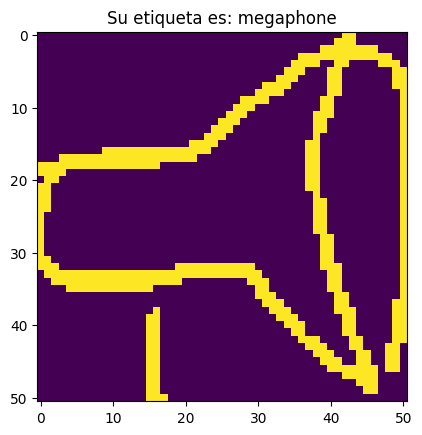

In [ ]:
import matplotlib.pyplot as plt
import random

# Image number
n = random.randrange(0, len(data_numpy) , 1)

plt.figure()
plt.imshow(data_sample_images[n])  # We use cmap='gray' for gray scale images
plt.title(f"Your labels is: {data_sample_labels[n]}")
plt.axis() 
plt.show()

Class Distribution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extraer las etiquetas
labels = np.array([item[1] for item in data_numpy])

# Contar la frecuencia de cada etiqueta
unique_labels, counts = np.unique(labels, return_counts=True)

# Graficar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Example Numbers')
plt.title('data_numpy class distribution')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Divide datates in train and test (80/20), without stratify.

In [ ]:
from sklearn.model_selection import train_test_split

# Divide Data
X_train, X_test, y_train, y_test = train_test_split(
    data_sample_images, data_sample_labels, test_size=0.2, random_state=42)

## Principal Functions

Transformations

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Transformation to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Dataset personalizado para PyTorch
class QuickDrawDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images*255  # Nueva escala ajustada
        self.labels = labels
        self.transform = transform

        # Crear el mapeo de clases a índices solo una vez
        self.classes = list(set(labels))  # Todas las clases únicas
        self.class_to_label = {cls: idx for idx, cls in enumerate(self.classes)}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx] # Número total de imágenes en el dataset
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        
        # Convertir la etiqueta en el índice correspondiente
        label = self.class_to_label[label]
        label = torch.tensor(label, dtype=torch.long)  # Aseguramos que sea un tensor de tipo entero
        return img, label
    

train_dataset = QuickDrawDataset(X_train, y_train, transform=transform)
val_dataset = QuickDrawDataset(X_test, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=5000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=5000, shuffle=False)
    

## Convolution Neural Network (Best Version)

In [ ]:
import torch.nn as nn
import math

# Best CNN
class CNN(nn.Module):
    def __init__(self, filter_size, stride, padding, fc1_size, num_classes):
        super(CNN, self).__init__()
        
        # Parámetros iniciales
        print(f"Process begin: CNN de {filter_size} kernels, stride {stride}, padding {padding} y FC size {fc1_size}")
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=filter_size, stride=stride, padding=padding)
        self.pool1 = nn.MaxPool2d(kernel_size=filter_size, stride=stride)
        
        # Calculate size before convolution and pooling
        input_size = 51  # Initial size 51x51
        conv_output_size = math.floor((input_size + 2 * padding - filter_size) / stride + 1)
        pool_output_size = math.floor((conv_output_size - filter_size) / stride + 1)

        print(f"{conv_output_size} = {(input_size + 2 * padding - filter_size) / stride + 1}")
        print(f"{pool_output_size} = {(conv_output_size - filter_size) / stride + 1}")
        
        # FC Size
        flattened_size = 32 * pool_output_size * pool_output_size
        print(f"Size before convolution and pooling: {flattened_size}")
        
        
        self.fc1 = nn.Linear(flattened_size, fc1_size)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(fc1_size, num_classes)
        
        # Activaciones
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

## Training Cycle

### Inputs and Outputs of the train_model Function

Inputs:
1. model:
- **Type**: torch.nn.Module
- **Description**: The neural network model that will be trained and validated.
	2.	train_loader:
- **Type**: torch.utils.data.DataLoader
- **Description**: DataLoader containing the training data organized in batches.
	3.	val_loader:
- **Type**: torch.utils.data.DataLoader
- **Description**: DataLoader containing the validation data organized in batches.
	4.	criterion:
- **Type**: torch.nn.Module (e.g., torch.nn.CrossEntropyLoss)
- **Description**: Loss function that measures the difference between the model’s predictions and the actual labels.
	5.	optimizer:
- **Type**: torch.optim.Optimizer (e.g., torch.optim.SGD, torch.optim.Adam)
- **Description**: Optimizer that adjusts the model weights based on the loss function.
	6.	epochs (optional):
- **Type**: int
- **Description**: Number of iterations (epochs) for training the model. Defaults to 1000.
	7.	early_stopping_patience (optional):
- **Type**: int
- **Description**: Number of epochs without improvement in validation loss before early stopping is triggered. Defaults to 15.

In [ ]:
# FEEV training cycle
def train_cicle(model, train_loader, val_loader, criterion, optimizer, epochs=1000, early_stopping_patience=15):
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
    print(f"Usando el dispositivo: {device}")

    # Move model to device
    model = model.to(device)

    best_val_loss = float('inf')
    early_stopping_counter = 0

    # Metrics List
    train_losses, val_losses, val_accuracies = [], [], []
    y_true = []
    y_pred = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            # Secure teh right form of labels and images
            if len(inputs.shape) == 3:  # If one chanel dimension missed
                inputs = inputs.unsqueeze(1)
            if len(labels.shape) > 1:  # If labels have one more dimension
                labels = labels.squeeze()
            
            # move to device
            inputs = inputs.to(device,dtype=torch.float32) # Images
            labels = labels.to(device, dtype=torch.long) # Labels
            outputs = model(inputs)

            # Forward and loss calculation
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            
            # Backward y optimization
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Training loss media
        train_loss /= len(train_loader)
        train_losses.append(train_loss) #/ len(train_loader))

        # Evaluate 
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        y_pred_prob = []  
        y_true_binarized = []  
    
        with torch.no_grad():
            for inputs, labels in val_loader:
                
                
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()
                
                # Predictions
                _, predicted = torch.max(outputs, 1)
                y_pred.extend(predicted.cpu().numpy())  # Save predictions
                y_true.extend(labels.cpu().numpy())
                probas = F.softmax(outputs, dim=1).cpu().numpy()  # softmax
                y_pred_prob.extend(probas)
                y_true_binarized.extend(label_binarize(labels.cpu().numpy(), classes=range(len(classes))))
                
                
                # saving
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        
        val_loss /= len(val_loader)
        accuracy = 100 * correct / total if total > 0 else 0
        val_losses.append(val_loss)
        val_accuracies.append(accuracy)
        y_pred_prob = np.array(y_pred_prob)
        y_true_binarized = np.array(y_true_binarized)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Val Loss: {best_val_loss:.4f}")
                break
        print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {accuracy:.2f}%")
    
    return train_losses, val_losses, val_accuracies,outputs, y_true, y_pred, y_true_binarized, y_pred_prob

# Configuration
filter_size = 5
stride = 2
padding = 1
fc1_size = 64
classes = list(set(data_sample_labels))
num_classes = len(classes)
learning_rate = 0.1

# Training
epochs = 1000
early_stopping_patience = 15
model = CNN(filter_size, stride, padding, fc1_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01) # Learning rate 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

train_loss, val_loss, val_accur, outputs, y_true, y_pred, y_true_binarized, y_pred_prob  = train_cicle(
    model, train_loader, val_loader, criterion, optimizer, epochs=epochs)

#### Outputs:

1. **train_losses:**
    - **Type:** `list[float]`
    - **Description:** A list containing the average training loss for each epoch.

2. **val_losses:**
    - **Type:** `list[float]`
    - **Description:** A list containing the average validation loss for each epoch.

3. **val_accuracies:**
    - **Type:** `list[float]`
    - **Description:** A list containing the accuracy on the validation set for each epoch.

4. **accuracy:**
    - **Type:** `float`
    - **Description:** The final accuracy achieved on the validation set.

5. **outputs:**
    - **Type:** `torch.Tensor`
    - **Description:** The model's final predictions (untransformed logits) generated during the validation phase.

6. **y_pred:**
    - **Type:** `list[int]`
    - **Description:** A list containing the predicted labels accumulated during the validation epochs.

7. **y_true:**
    - **Type:** `list[int]`
    - **Description:** A list containing the true labels corresponding to the validation samples.

## MLP Model

In [ ]:
# MLP model with variable hidden size
class MLP(nn.Module):
    def __init__(self, input_size=2601, hidden_size=500, output_size=10):
        super(MLP, self).__init__()

        # if there hidden size
        if hidden_size > 0:
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.sigmoid = nn.Sigmoid()
            self.fc2 = nn.Linear(hidden_size, output_size)
            
            # Xavier init
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        
        else:  # No hidden size
            self.fc1 = nn.Linear(input_size, output_size)
            self.fc2 = None
            
            # Xavier Init
            nn.init.xavier_uniform_(self.fc1.weight)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        if self.fc2:  # With hidden layer
            x = self.sigmoid(self.fc1(x))
            x = self.fc2(x)
        else:  # No hidden layer
            x = self.fc1(x)
        return x
    

# Network configuration
input_size = 51 * 51
hidden_size = 500 #[25, 100, 300, 1000, 0]  # N Values (0 = without hidden layer)
epochs = 1000
classes = list(set(data_sample_labels))
num_classes = len(classes)
learning_rate = 0.01